In [1]:
#import tensorrt as trt
from tensorrt_util import TensorrtModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random
import cv2


import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from tqdm.auto import tqdm

from dataloading.ouster import OusterCrop, OusterNormalize, OusterDataset
from trainer import Trainer

%load_ext autoreload
%autoreload 2

In [2]:
def crop(img):
    fov = 256
    top = 54
    left = 256 - fov // 2
    height = 68
    width = 264

    img = img[:, 256:-256]
    img = img[top:top+height, left:left + width]
    return img

def normalise(img):
    return (img / 255)

def preprocess(img):
    img = crop(img)
    img = normalise(img)
    return img

def read_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[:,:,1]
    img = np.expand_dims(img, axis=2)
    img = np.array(img, dtype=np.float32, order='C')
    img = preprocess(img)
    return img

def create_tensor(img):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
    img_tensor = torch.FloatTensor(img).to(device).permute(2, 0, 1).unsqueeze(0)
    return img_tensor

In [23]:
root_path = Path("/media/romet/data2/datasets/rally-estonia/dataset")
valid_paths = [root_path / "2021-10-26-10-49-06_e2e_rec_ss20_elva", 
               root_path / "2021-10-26-11-08-59_e2e_rec_ss20_elva_back"]
validset = OusterDataset(valid_paths, channel="intensity")

Using only lidar channel intensity
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-26-10-49-06_e2e_rec_ss20_elva: 11016
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-26-11-08-59_e2e_rec_ss20_elva_back: 11094


(68, 264, 1)


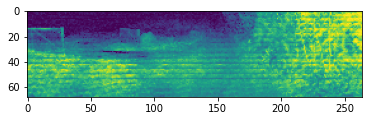

In [4]:
img = read_image(validset.frames.image_path.to_numpy()[0])
print(img.shape)
plt.imshow(img)

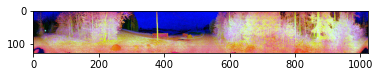

In [5]:
image = torchvision.io.read_image(validset.frames.image_path.to_numpy()[0])
plt.imshow(image.permute(1, 2, 0))

In [6]:
model_path = "models/20211123162011_lidar-intensity"
tensorrt_model = TensorrtModel(f"{model_path}/best.onnx")

Loading ONNX file from path models/20211123162011_lidar-intensity/best.onnx...
Beginning ONNX file parsing
Completed parsing of ONNX file
Building an engine from file models/20211123162011_lidar-intensity/best.onnx; this may take a while...
Completed creating Engine


In [7]:
tensorrt_predictions = []

for path in tqdm(validset.frames.image_path.to_numpy()):
    img = read_image(path)
    img = np.transpose(img, [2, 0, 1])
    img = np.expand_dims(img, axis=0)
    img = np.array(img, dtype=np.float32, order='C')
    prediction = tensorrt_model.predict(img)
    tensorrt_predictions.append(prediction)

  0%|          | 0/22110 [00:00<?, ?it/s]

In [8]:
import torch
from network import PilotNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch_model = PilotNet(n_input_channels=1)
torch_model.load_state_dict(torch.load(f"{model_path}/best.pt"))
torch_model.to(device)
torch_model.eval()

PilotNet(
  (features): Sequential(
    (0): Conv2d(1, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (4): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (7): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.01)
    (15): Flatten(st

In [9]:
torch_predictions = []

for path in tqdm(validset.frames.image_path.to_numpy()):
    img = read_image(path)
    img_tensor = create_tensor(img)
    prediction = torch_model(img_tensor).squeeze(1)
    torch_predictions.append(prediction.item())

  0%|          | 0/22110 [00:00<?, ?it/s]

In [10]:
from torchvision import transforms

trainer = Trainer()
tr = transforms.Compose([OusterCrop(), OusterNormalize()])
validset_tr = OusterDataset(valid_paths, tr, channel="intensity")
validloader_tr = torch.utils.data.DataLoader(validset_tr, batch_size=64, shuffle=False,
                                         num_workers=16, pin_memory=True, persistent_workers=True)
torch_transforms_predictions = trainer.predict(torch_model, validloader_tr)

Using only lidar channel intensity
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-26-10-49-06_e2e_rec_ss20_elva: 11016
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-26-11-08-59_e2e_rec_ss20_elva_back: 11094


  0%|          | 0/346 [00:00<?, ?it/s]

In [11]:
from closed_loop_metrics import calculate_open_loop_metrics

calculate_open_loop_metrics(torch_transforms_predictions, validset_tr.frames.steering_angle.to_numpy(), fps=10)

{'mae': 7.4622331947855844,
 'rmse': 24.69675782486085,
 'max': 675.5087344719996,
 'whiteness': 104.37723,
 'expert_whiteness': 22.923865138522743}

In [12]:
calculate_open_loop_metrics(tensorrt_predictions, validset_tr.frames.steering_angle.to_numpy(), fps=10)

{'mae': 7.462322041709014,
 'rmse': 24.69801081467792,
 'max': 675.5246036126246,
 'whiteness': 104.36204,
 'expert_whiteness': 22.923865138522743}

In [13]:
calculate_open_loop_metrics(torch_predictions, validset_tr.frames.steering_angle.to_numpy(), fps=10)

{'mae': 7.4623811034712,
 'rmse': 24.698621646772974,
 'max': 675.639439315072,
 'whiteness': 104.37289485727626,
 'expert_whiteness': 22.923865138522743}

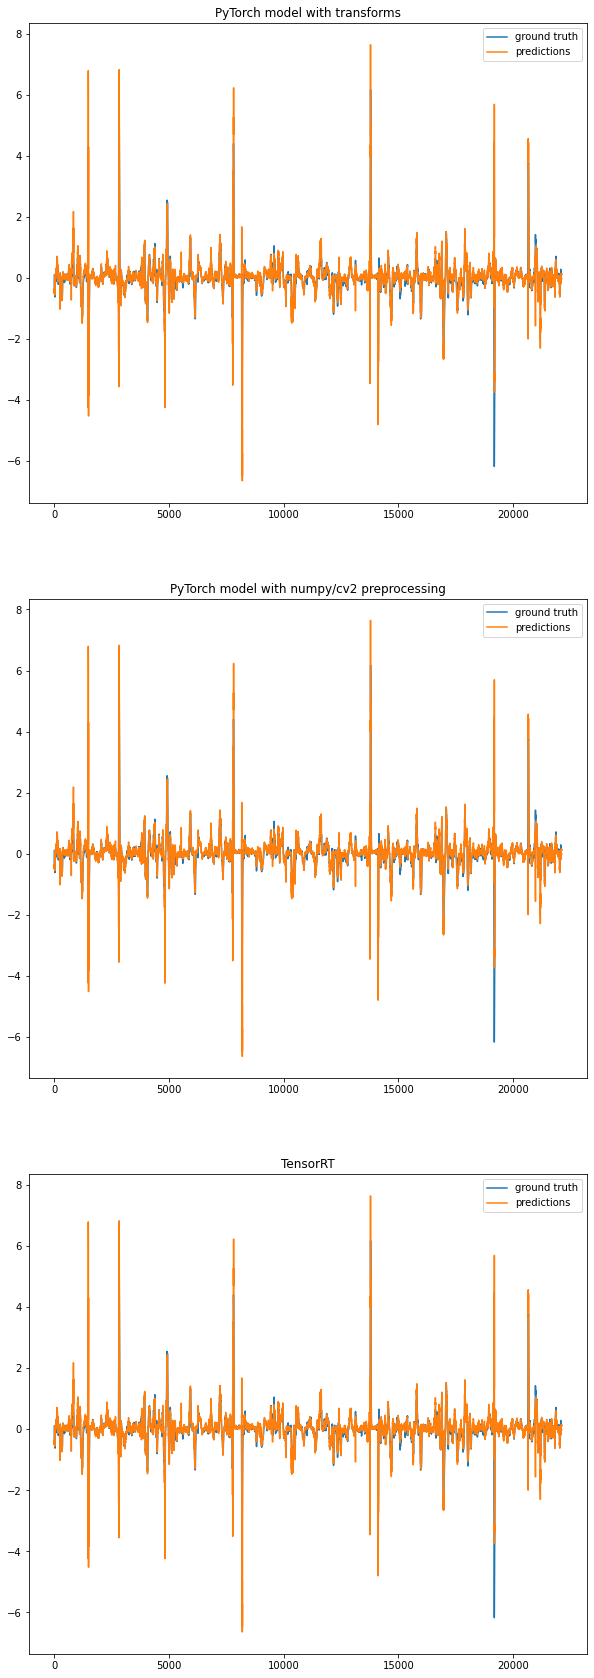

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 30))

ax1.plot(validset.frames.steering_angle.to_numpy())
ax1.plot(torch_transforms_predictions)
ax1.legend(["ground truth", "predictions"])
ax1.set_title("PyTorch model with transforms")

ax2.plot(validset.frames.steering_angle.to_numpy())
ax2.plot(torch_predictions)
ax2.legend(["ground truth", "predictions"])
ax2.set_title("PyTorch model with numpy/cv2 preprocessing")

ax3.plot(validset.frames.steering_angle.to_numpy())
ax3.plot(tensorrt_predictions)
ax3.legend(["ground truth", "predictions"])
ax3.set_title("TensorRT");

In [49]:
import math
import cv2
import shutil
from skimage import io
import os
from moviepy.editor import ImageSequenceClip


def draw_steering_angle(frame, steering_angle, steering_wheel_radius, steering_position, size, color):
    steering_angle_rad = math.radians(steering_angle)
    x = steering_wheel_radius * np.cos(np.pi / 2 + steering_angle_rad)
    y = steering_wheel_radius * np.sin(np.pi / 2 + steering_angle_rad)
    cv2.circle(frame, (steering_position[0] + int(x), steering_position[1] - int(y)), size, color, thickness=-1)
    
def draw_frames(dataset, predicted_angles, temp_frames_folder):
    
    for frame_index, data in tqdm(enumerate(dataset), total=len(dataset)):
        frame = data["image"].permute(1, 2, 0).cpu().numpy()
        frame = cv2.merge([frame, frame, frame])
        true_angle = math.degrees(data["steering_angle"])
        pred_angle = math.degrees(predicted_angles[frame_index])
        
        cv2.putText(frame, 'True: {:.2f}deg'.format(true_angle), (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2,
                    cv2.LINE_AA)
        cv2.putText(frame, 'Pred: {:.2f}deg'.format(pred_angle), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2,
                    cv2.LINE_AA)
    
        radius = 50
        steering_pos = (100, 128)
        cv2.circle(frame, steering_pos, radius, (255, 255, 255), 5)

        draw_steering_angle(frame, true_angle, radius, steering_pos, 9, (0, 255, 0))
        draw_steering_angle(frame, pred_angle, radius, steering_pos, 6, (255, 0, 0))
            
        io.imsave(f"{temp_frames_folder}/{frame_index + 1:05}.jpg", frame)
        

def convert_frames_to_video(frames_folder, output_video_path, fps=25):
    output_folder = Path(os.path.split(output_video_path)[:-1][0])
    output_folder.mkdir(parents=True, exist_ok=True)

    p = Path(frames_folder).glob('**/*.jpg')
    image_list = sorted([str(x) for x in p if x.is_file()])

    print("Creating video {}, FPS={}".format(frames_folder, fps))
    clip = ImageSequenceClip(image_list, fps=fps)
    clip.write_videofile(output_video_path)

In [50]:
video_name = "lidar_intensity"
temp_frames_folder = Path(f"./{video_name}_temp_frames")
shutil.rmtree(temp_frames_folder, ignore_errors=True)
temp_frames_folder.mkdir()

draw_frames(validset, tensorrt_predictions, temp_frames_folder)
output_video = f"output/{video_name}.mp4"
convert_frames_to_video(temp_frames_folder, output_video, fps=10.0)

shutil.rmtree(temp_frames_folder, ignore_errors=True)

  0%|          | 0/22110 [00:00<?, ?it/s]

Creating video lidar_intensity_temp_frames, FPS=10.0
Moviepy - Building video output/lidar_intensity.mp4.
Moviepy - Writing video output/lidar_intensity.mp4



Moviepy - Done !
Moviepy - video ready output/lidar_intensity.mp4


In [ ]:
from IPython.display import HTML


HTML(f"""
<video width="640" height="480" controls>
  <source src="{output_video}" type="video/mp4">
</video>
""")

In [ ]:
output_video